<a href="https://colab.research.google.com/github/tianhaoz95/ultron/blob/dev%2Ftry-atari-game/notebooks/prototype_atari_with_actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install gym pyvirtualdisplay tqdm > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gputil > /dev/null 2>&1
!pip install pyglet==1.2.4 > /dev/null 2>&1

In [5]:
import tensorflow as tf
import GPUtil
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  try:
    print('ERROR: Not connected to a TPU runtime!')
    GPUs = GPUtil.getGPUs()
    print('GPU count: ' + str(len(GPUs)))
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)
  except:
    print('Using CPU')

Tensorflow version 2.2.0
Running on TPU  ['10.61.95.42:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.61.95.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.95.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
import gym
import threading
import math
import glob
import io
import base64
import multiprocessing
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from gym.wrappers import Monitor
from tensorflow import keras
from os import path
from time import sleep
from tqdm.notebook import tqdm
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1007'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1007'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [7]:
print('using tensorflow', tf.__version__)

using tensorflow 2.2.0


In [0]:
def show_video(id='video', base='.'):
  mp4list = glob.glob(f'{path.join(base, id)}/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env, id='video', base='.'):
  wrapped_env = Monitor(env, path.join(base, id), force=True)
  return wrapped_env

In [0]:
class PipelineArgs():
  def __init__(self,
               game_name='Acrobot-v1',
               mode='train',
               max_eps=100,
               update_freq=20,
               gamma=0.99,
               model_path='.',
               load_model=False,
               max_testing_steps=1000,
               round_cnt=10,
               lr=0.001):
    self.game_name = game_name
    self.mode = mode
    self.gamma = gamma
    self.update_freq = update_freq
    self.lr = lr
    self.max_eps = max_eps
    self.load_model = load_model
    self.model_path = model_path
    self.max_testing_steps = max_testing_steps
    self.round_cnt = round_cnt

In [0]:
class History():
  def __init__(self, args):
    self.train_rewards = []
    self.test_rewards = []
    self.losses = []
    self.args = args
  
  def record_train_snapshot(self, reward, loss):
    self.train_rewards.append(reward)
    self.losses.append(loss)
  
  def record_test_reward(self, reward):
    self.test_rewards.append(reward)

  def visualize(self):
    plt.figure()
    plt.plot(self.losses)
    plt.show()

  def save(self):
    # self.history.to_csv(path.join(self.args.model_path, 'history.csv'))
    print('Not implemented')
  
  def load(self):
    """
    if path.exists(
        path.join(
            self.args.model_path, 'history.csv')) and self.args.load_model:
      self.history = pd.DataFrame()
      self.history.read_csv(path.join(self.args.model_path, 'history.csv'))
    """
    print('Not implemented')

In [0]:
class Memory():
  def __init__(self):
    self.states = []
    self.actions = []
    self.rewards = []
  
  def store(self, state, action, reward):
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)

  def clear(self):
    self.states = []
    self.actions = []
    self.rewards = []

In [0]:
class Worker(threading.Thread):
  # The cumulative episode played
  global_eps = 0
  best_score = 0
  lock = threading.Lock()

  def __init__(self,
               args,
               action_size,
               state_size,
               global_model,
               opt,
               pbar,
               logger):
    super(Worker, self).__init__()
    self.args = args
    self.game_name = self.args.game_name
    self.env = gym.make(self.game_name)
    self.action_size = action_size
    self.state_size = state_size
    self.local_model = ActorCriticModel(self.state_size, self.action_size)
    self.eps_loss = 0
    self.opt = opt
    self.global_model = global_model
    self.pbar = pbar
    self.logger = logger

  def compute_loss(self, done, new_state, memory):
    if done:
      reward_sum = 0
    else:
      reward_sum = self.local_model(
          tf.convert_to_tensor(
              new_state[None, :],
              dtype=tf.float32))[-1].numpy()[0]
    discounted_rewards = []
    for reward in memory.rewards[::-1]:
      reward_sum = reward + self.args.gamma * reward_sum
      discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    past_states = np.array(memory.states)
    logits, values = self.local_model(
        tf.convert_to_tensor(past_states, dtype=tf.float32))
    advantage = tf.convert_to_tensor(
        np.array(discounted_rewards)[:, None], dtype=tf.float32) - values
    # Calculate the loss for value function which mean how off is our
    # predicted value from the true value estimated from the discounted
    # reward.
    value_loss = advantage ** 2
    # Calculate the policy loss
    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=policy, logits=logits)
    policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=memory.actions, logits=logits)
    policy_loss *= tf.stop_gradient(advantage)
    policy_loss -= 0.01 * entropy
    # Combine the value and policy loss to be a single trainable
    total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
    return total_loss

  def compute_and_apply_gradient(self, done, new_state, mem):
    with tf.GradientTape() as tape:
      total_loss = self.compute_loss(done, new_state, mem)
    self.eps_loss += total_loss
    grads = tape.gradient(
        total_loss, self.local_model.trainable_weights)
    self.opt.apply_gradients(zip(
        grads, self.global_model.trainable_weights))
    self.local_model.set_weights(self.global_model.get_weights())
    return total_loss

  def run(self):
    # Prepare variables
    mem = Memory()
    total_steps = 1
    # Check the maximum episode of learning is reached
    while Worker.global_eps < self.args.max_eps:
      current_state = self.env.reset()
      mem.clear()
      done = False
      ep_reward = 0
      self.eps_loss = 0
      time_count = 0
      ep_steps = 0
      # Check if the game is over
      while not done:
        # Get the policy and play the game
        logits, _ = self.local_model(
            tf.convert_to_tensor(np.array([current_state]), dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(self.action_size, p=probs.numpy()[0])
        new_state, reward, done, info = self.env.step(action)
        if reward <= 0:
          reward -= -0.01
        if done:
          reward = -1.0
        ep_reward += reward
        mem.store(current_state, action, reward)
        # If the explore time limit has been reached or
        # the game is over, then update the models
        if time_count >= self.args.update_freq or done:
          loss = self.compute_and_apply_gradient(done, new_state, mem)
          mem.clear()
          time_count = 0
          if done:
            with Worker.lock:
              self.logger.record_train_snapshot(ep_reward, loss)
              if Worker.global_eps == 0 or ep_reward > Worker.best_score:
                self.global_model.save_weights(
                    path.join(self.args.model_path, 'best.h5'))
                Worker.best_score = ep_reward
              self.global_model.save_weights(
                  path.join(self.args.model_path, 'backup.h5'))
              Worker.global_eps += 1
              self.pbar.set_description(
                  f'step: {ep_steps}, reward {round(ep_reward, 2)}/{round(Worker.best_score, 2)}')
              self.pbar.update(1)
        ep_steps += 1
        time_count += 1
        current_state = new_state
        total_steps += 1

In [0]:
class ActorCriticModel(keras.Model):
  def __init__(self, state_size, action_size):
    super(ActorCriticModel, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.conv_0 = keras.layers.Conv2D(
        filters=32,
        strides=(2, 2),
        kernel_size=4,
        activation='relu',
        padding='same',
        kernel_initializer='glorot_uniform',
        input_shape=(160, 160, 3))
    self.conv_1 = keras.layers.Conv2D(
        filters=32,
        activation='relu',
        strides=(2, 2),
        padding='same',
        kernel_initializer='glorot_uniform',
        kernel_size=4)
    self.conv_2 = keras.layers.Conv2D(
        filters=32,
        activation='relu',
        strides=(2, 2),
        padding='same',
        kernel_initializer='glorot_uniform',
        kernel_size=4)
    self.conv_3 = keras.layers.Conv2D(
        filters=32,
        activation='relu',
        strides=(2, 2),
        padding='same',
        kernel_initializer='glorot_uniform',
        kernel_size=4)
    self.avg_pooling = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
    self.flatten = keras.layers.Flatten()
    self.policy_dense_0 = keras.layers.Dense(
        64, kernel_initializer='glorot_uniform', activation='relu')
    self.policy_logits = keras.layers.Dense(self.action_size, activation='relu')
    self.value_dense = keras.layers.Dense(
        64, kernel_initializer='glorot_uniform', activation='relu')
    self.value = keras.layers.Dense(1)
  
  def call(self, inputs):
    x = tf.image.resize(inputs, (160, 160))
    x = self.conv_0(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.avg_pooling(x)
    x = self.flatten(x)
    p = self.policy_dense_0(x)
    logits = self.policy_logits(p)
    v = self.value_dense(x)
    values = self.value(v)
    return logits, values

In [0]:
class BaselineModel():
  def __init__(self):
    print('not implemented')

In [0]:
class MasterAgent():
  def __init__(self, args):
    self.args = args
    self.game_name = self.args.game_name
    env = gym.make(self.game_name)
    self.action_size = env.action_space.n
    self.history = History(self.args)
    self.state_size = env.observation_space.shape[0]
    self.opt = tf.optimizers.Adam(self.args.lr)
    print('state_size: ', env.observation_space.shape)
    print('action_size: ', self.action_size)
    self.global_model = ActorCriticModel(self.state_size, self.action_size)
    self.global_model(
      tf.convert_to_tensor(
      np.random.random((5, 210, 160, 3)),
      dtype=tf.float32))
    if path.exists(
        path.join(self.args.model_path, 'backup.h5')) and self.args.load_model:
      self.global_model.load_weights(
          path.join(self.args.model_path, 'backup.h5'))
  
  def train_sync_round(self):
    pbar = tqdm(total=self.args.max_eps)
    worker = Worker(self.args, self.action_size, self.state_size,
                    self.global_model, self.opt, pbar, self.history)
    worker.run()
    pbar.close()

  def train_sync(self):
    for r in range(self.args.round_cnt):
      Worker.global_eps = 0
      self.train_sync_round()
      self.eval(f'test at round {str(r)}')
      self.history.visualize()
    print('all done')
  
  def train_async_round(self):
    pbar = tqdm(total=self.args.max_eps + multiprocessing.cpu_count())
    Worker.global_eps = 0;
    workers = [
      Worker(self.args, self.action_size, self.state_size,
             self.global_model, self.opt, pbar, self.history)
      for i in range(multiprocessing.cpu_count())
    ]
    worker_pbar = tqdm(total=len(workers))
    worker_pbar.set_description(f'starting {len(workers)} workers')
    for i, worker in enumerate(workers):
      worker.start()
      worker_pbar.update(1)
    worker_pbar.close()
    [w.join() for w in workers]
    pbar.close()
  
  def train_async(self):
    for r in range(self.args.round_cnt):
      Worker.global_eps = 0
      self.train_async_round()
      self.eval(f'test at round {str(r)}')
      self.history.visualize()
    print('all done')

  def eval(self, id):
    self.play(load=False, id=id, base=self.args.model_path)
  
  def play(self, load=True, id='video', base='./'):
    env = wrap_env(gym.make(self.args.game_name), id=id, base=base)
    state = env.reset()
    model_snapshot = self.global_model
    if load and path.exists(
        path.join(self.args.model_path, 'best.h5')):
      print('load pre-trained model')
      model_snapshot.load_weights(
          path.join(self.args.model_path, 'best.h5'))
    done = False
    trial_steps = 0
    pbar = tqdm(total=self.args.max_testing_steps)
    cumulative_reward = 0
    while (not done) and (trial_steps < self.args.max_testing_steps):
      state_input = tf.convert_to_tensor(state[None, :], dtype=tf.float32)
      logit, _ = model_snapshot(state_input)
      policy = tf.nn.softmax(logit)
      action = np.argmax(policy)
      state, reward, done, _ = env.step(action)
      cumulative_reward += reward
      trial_steps += 1
      pbar.update(1)
    print(f'The final reward for this trial is {cumulative_reward}')
    pbar.close()
    env.close()
    show_video(id=id, base=base)

In [0]:
def gym_sanity_check(args):
  print('starting gym environment sanity check')
  env = wrap_env(gym.make(args.game_name))
  inital_observation = env.reset()
  sample_action = env.action_space.sample()
  print('observation shape: ', np.array(inital_observation).shape)
  print('sample action: ', sample_action)
  for _ in range(20):
    observation = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        observation, _, done, _ = env.step(action)
  env.close()
  show_video()

In [0]:
def entry_point(args):
  if args.mode == 'sanity':
    gym_sanity_check(args)
  if args.mode == 'play':
    master = MasterAgent(args)
    master.play()
  if args.mode == 'train_sync':
    master = MasterAgent(args)
    master.train_sync()
  if args.mode == 'train_async':
    master = MasterAgent(args)
    master.train_async()
  print('Hello World')

state_size:  (210, 160, 3)
action_size:  4


The final reward for this trial is 0.0



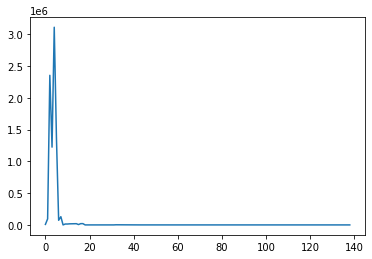

The final reward for this trial is 0.0



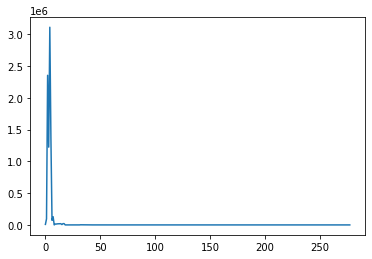

The final reward for this trial is 0.0



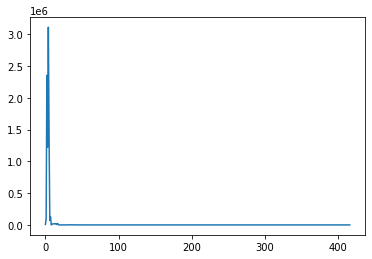

The final reward for this trial is 0.0



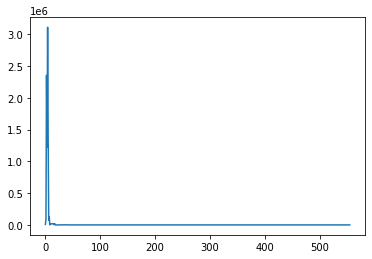

The final reward for this trial is 0.0



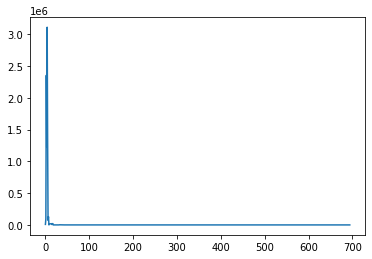

The final reward for this trial is 0.0



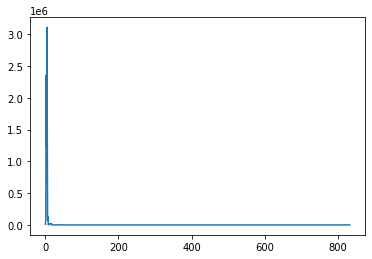

The final reward for this trial is 0.0



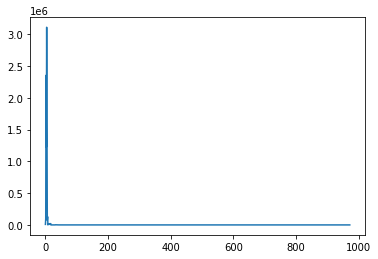

The final reward for this trial is 0.0



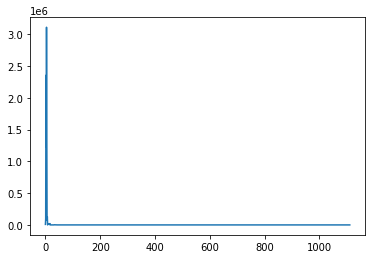

In [0]:
entry_point(
    PipelineArgs(
        game_name='Breakout-v0',
        update_freq=32,
        max_eps=100,
        model_path='/content/drive/My Drive/colab_storage',
        max_testing_steps=1000,
        load_model=False,
        round_cnt=60,
        mode='train_async'))